# Проект 5. Алгоритм кредитного скоринга

## Цель проекта:
Написать скоринговую модель предсказания дефолта клиентов банка.

## Описание датасета
1. **client_id** - идентификатор клиента;
2. **education** - уровень образования;
3. **sex** - пол заёмщика;
4. **age** - возраст заёмщика;
5. **car** - флаг наличия автомобиля;
6. **car_type** - флаг автомобиля-иномарки;
7. **decline_app_cnt** - количество отказанных прошлых заявок;
8. **good_work** - флаг наличия «хорошей» работы;
9. **bki_request_cnt** - количество запросов в БКИ;
10. **home_address** - категоризатор домашнего адреса;
11. **work_address** - категоризатор рабочего адреса;
12. **income** - доход заёмщика;
13. **foreign_passport** - наличие загранпаспорта;
14. **sna** - связь заемщика с клиентами банка;
15. **first_time** - давность наличия информации о заемщике;
16. **score_bki** - скоринговый балл по данным из БКИ;
17. **region_rating** - рейтинг региона;
18. **app_date** - дата подачи заявки;
19. **default** - наличие дефолта.


**Целевая переменная** - "default"

## Задачи проекта
 1. Провести первичную обработку данных. Написать вспомогательные функции;
 2. Обнаружить и устранить выбросы для числовых переменных;
 3. Провести анализ основных переменных, оцените их важность и вклад для модели, сгенерировать новые признаки
 4. Составить отчёт по результатам анализа данных;
 5. Обучить модель и улучшить ее результаты на основе подбора параметра регуляризации.
 
## Этапы выполнения проекта
 1. **[Импорт библиотек и загрузка данных](#Импорт-библиотек-и-загрузка-данных)**
 2. **[Написание функций для обработки и анализа данных](#Функции-для-обработки-и-анализа-данных)**
 3. **[Обзор данных](#Обзор-данных)**
 4. **[Обработка данных](#Обработка-данных)**
 5. **[Значимость признаков](#Значимость-признаков)**
 6. **[Обучение модели](#Обучение-модели)** 

In [1]:
# импортируем необходимые библиотеки
import warnings
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.metrics import confusion_matrix, auc, roc_auc_score, roc_curve,plot_confusion_matrix,f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold,RandomizedSearchCV
from sklearn.feature_selection import f_classif, mutual_info_classif
from xgboost import XGBClassifier

import numpy as np
import pandas as pd
from datetime import datetime
import pandas_profiling
import random

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

warnings.simplefilter('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [2]:
# установим параметр random_seed для воспроизводимости экспериментов и текущую дату
RANDOM_SEED = 42
CURRENT_DATE = datetime.now()

In [3]:
DATA_DIR = '/kaggle/input/sf-dst-scoring/'
df_train = pd.read_csv(DATA_DIR+'train.csv')
df_test = pd.read_csv(DATA_DIR+'test.csv')
sample_submission = pd.read_csv(DATA_DIR+'sample_submission.csv')

In [4]:
# для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1
df_test['sample'] = 0
df_test['default'] = 0

df = df_train.append(df_test, sort=False).reset_index(drop=True)

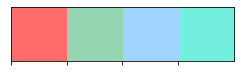

In [5]:
custom_colors = ["#ff6b6b", "#95d5b2", "#a2d2ff", "#72efdd"]
sns.palplot(sns.color_palette(custom_colors))

# Функции для обработки и анализа данных

In [6]:
def fill_na_values(column, data):
    '''Функция для заполнения пустых значений в зависимости от типа данных в столбце. 
    Если данные числовые, то пропуск будет заполнен медианой, 
    а остальные будут заполнены рандомно с учетом вероятности.
    '''
    if data.loc[:, column].dtypes == np.dtype('O'):
        values = data[column].value_counts()
        index = data[data[column].isna() == True].index
        new_value = pd.Series(random.choices(
            values.index, values, k=data[column].isna().sum()))
        new_value.index = index
        return data[column].fillna(new_value)
    else:
        return data[column].fillna(data[column].median())

In [7]:
def parsing_all_columns_data(data):
    '''Функция для анализа всех столбцов на количество 
    уникальных значений и количество пропусков'''
    
    for col in data.columns:
        unique_values = len(data[col].value_counts())
        empty_values = data[col].isna().sum()
        print(
            f"В столбце '{col}' уникальных значений = {unique_values} ,а количество пропусков = {empty_values}.")
        print(
            f'Процент пропусков = {round(empty_values*100/data.shape[0],1)}%')        

In [8]:
def definition_duplicates(data):
    '''Функция для определия дубликатов в датасете
    '''

    duplicate_data = data.duplicated().sum()
    if duplicate_data > 0:
        print('В датасете присутствуют дубликаты')
    else:
        print('В датасете дубликаты отсутствуют')

In [9]:
def cols_to_drop(data):
    '''Функция для определения столбцов, 
    не влияющих на целевую переменную'''

    # Поиск колонок с большим количеством пропусков, более 90%
    many_null_cols = [
        col for col in data.columns if data[col].isnull().sum() / data.shape[0] > 0.9]
    # Поиск колонок в которых одно из значений встречается > 95%
    big_top_value_cols = [col for col in data.columns if data[col].value_counts(
        dropna=False, normalize=True).values[0] > 0.95]
    # Поиск колонок в которых только одно значение
    one_value_cols = [col for col in data.columns if data[col].nunique() <= 1]

    return list(set(many_null_cols + big_top_value_cols + one_value_cols))

In [10]:
def group_col(x, perc25, median, perc75):
    '''Функция для разделения данных на 4 группы
    на основе квартилей распределения '''
    
    if x <= perc25:
        return 1
    elif perc25 < x <= median:
        return 2
    elif median < x <= perc75:
        return 3
    elif perc75 < x:
        return 4

# Обзор данных

In [11]:
# Проверка на успешность загрузки данных и краткий вывод таблицы с информацией
display(df.head())
df.info()

client_id   app_date education sex  age car car_type  decline_app_cnt  \
0      25905  01FEB2014       SCH   M   62   Y        Y                0   
1      63161  12MAR2014       SCH   F   59   N        N                0   
2      25887  01FEB2014       SCH   M   25   Y        N                2   
3      16222  23JAN2014       SCH   F   53   N        N                0   
4     101655  18APR2014       GRD   M   48   N        N                0   

   good_work  score_bki  bki_request_cnt  region_rating  home_address  \
0          0  -2.008753                1             50             1   
1          0  -1.532276                3             50             2   
2          0  -1.408142                1             80             1   
3          0  -2.057471                2             50             2   
4          1  -1.244723                1             60             2   

   work_address  income  sna  first_time foreign_passport  default  sample  
0             2   18000    4           1                N        0       1  
1             3   19000    4           1                N        0       1  
2             2   30000    1           4                Y        0       1  
3             3   10000    1           3                N        0       1  
4             3   30000    1           4                Y        0       1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [12]:
# Вывод количества строк и столбцов таблицы
print(
    f'Датасет состоит из {df.shape[0]} строк и {df.shape[1]} столбцов')

Датасет состоит из 110148 строк и 20 столбцов


In [13]:
# Подсчёт уникальных значений и количество пропусков в столбцак датасета
parsing_all_columns_data(df)

В столбце 'client_id' уникальных значений = 110148 ,а количество пропусков = 0.
Процент пропусков = 0.0%
В столбце 'app_date' уникальных значений = 120 ,а количество пропусков = 0.
Процент пропусков = 0.0%
В столбце 'education' уникальных значений = 5 ,а количество пропусков = 478.
Процент пропусков = 0.4%
В столбце 'sex' уникальных значений = 2 ,а количество пропусков = 0.
Процент пропусков = 0.0%
В столбце 'age' уникальных значений = 52 ,а количество пропусков = 0.
Процент пропусков = 0.0%
В столбце 'car' уникальных значений = 2 ,а количество пропусков = 0.
Процент пропусков = 0.0%
В столбце 'car_type' уникальных значений = 2 ,а количество пропусков = 0.
Процент пропусков = 0.0%
В столбце 'decline_app_cnt' уникальных значений = 24 ,а количество пропусков = 0.
Процент пропусков = 0.0%
В столбце 'good_work' уникальных значений = 2 ,а количество пропусков = 0.
Процент пропусков = 0.0%
В столбце 'score_bki' уникальных значений = 102618 ,а количество пропусков = 0.
Процент пропусков = 0.0

Как видим, пропуски есть только в столбце education (478), обработаем их позже

In [14]:
#  Поиск дубликатов в датасете
definition_duplicates(df)

В датасете дубликаты отсутствуют


In [15]:
# бинарные переменные
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']

# категориальные переменные
cat_cols = ['education', 'region_rating',
            'work_address', 'home_address', 'sna', 'first_time']

# числовые переменные
num_cols = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'score_bki']

In [16]:
# проведем первичный анализ данных
pandas_profiling.ProfileReport(df)

Summarize dataset:   0%|          | 0/33 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# ВЫВОДЫ:
* client_id - это идентификатор клиента, в модель включен не будет;
* app_date - необходимо преобразовать признак к формату datetime; на его основе можно сформировать новые признаки (разбить данные на года/сезоны/месяца или посчитать количество дней, прошедших с даты подачи заявки);
* education - пропуски в данных составляют ~0.4%, их можно обработать с помощью функции fill_na_values
* sex, car, car_type, foreign_passport - бинарные признаки, необходимо перекодировать их (заменить Y/N на 1/0)
* good_work - также бинарный признак
* age - числовой признак; возможно, имеет смысл разделить клиентов на группы по возрасту. также, у переменной тяжелый хвост, необходимо прологарифмировать признак
* decline_app_cnt - числовой признак, как и в предыдущем признаке, хвост распределения смещен, необходимо прологарифмировать. у более 80% клиентов этот признак равен 0. возможно, стоит ввести новый признак, показывающий клиентов, у которых отказов больше заданного порога
* score_bki - у признака нормальное распределение, в логарифмировании не нуждается
* bki_request_cnt - необходимо логарифмирование, т.к. хвост распределения смещен влево. Можно добавить новый признак, показывающий клиентов, которые часто (>3 раз) запрашивают данные в БКИ
* income - есть выбросы, аналогично предыдущему признаку нуждается в логарифмировании. Целесообразно данный признак разделить на 4 группы по уровню доходов
* region_rating,work_address, home_address, sna, first_time - категориальные признаки. На первый взгляд, в дополнительной предобработке не нуждаются. Далее, заменим их на dummy-переменные

<AxesSubplot:xlabel='default', ylabel='count'>

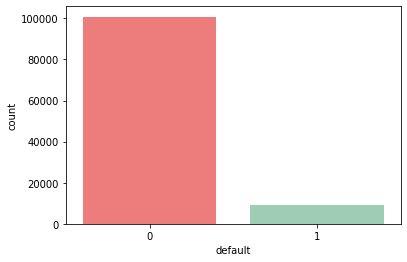

In [17]:
# Посмотрим на целевую переменную
sns.countplot(x='default', data=df, palette=[
              custom_colors[0], custom_colors[1]])

Очевидно, наблюдаем дисбаланс выборки - примеров одного класса значительно больше. Учтем этот момент при разделении выборки на обучающую и валидационнную.


# Обработка данных

## Дата

### app_date

In [18]:
# Преобразуем значение даты в dt формат
df.app_date = pd.to_datetime(df.app_date, format='%d%b%Y')

In [19]:
# Посмотрим, за какой период представлены данные и можно ли их разделить по годам/сезонам/месяцам
df.app_date.dt.month.value_counts()

3    31597
2    27097
4    26266
1    25188
Name: app_date, dtype: int64

In [20]:
# Как видим, есть данные только за 4 месяца, поэтому формируем новый признак - месяц подачи заявки
df['app_month'] = df.app_date.dt.month

In [21]:
# Определим количество прошедших дней с даты подачи заявки
df['days_since_app_date'] = (CURRENT_DATE-df['app_date']).dt.days

# Числовые переменные

### age

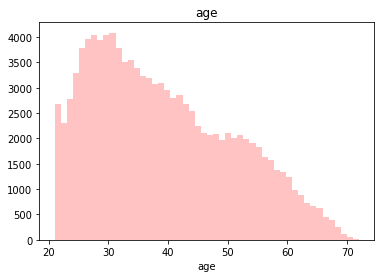

In [22]:
# Построим график распределения признака
plt.figure()
sns.distplot(df['age'], kde=False, rug=False,color=custom_colors[0])
plt.title('age')
plt.show()

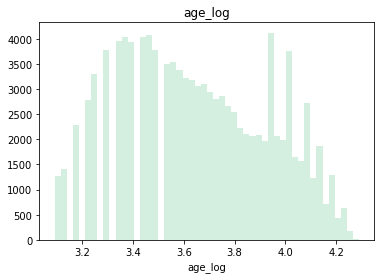

In [23]:
# У признака age тяжелый правый хвост, прологарифмируем его и построим новую гистограмму
df['age_log'] = df.age.apply(lambda x: np.log(x + 1))

plt.figure()
sns.distplot(df['age_log'][df['age_log'] > 0].dropna(), kde=False, rug=False, color=custom_colors[1])
plt.title('age_log')
plt.show()

In [24]:
df.age.describe()

count    110148.000000
mean         39.249410
std          11.518063
min          21.000000
25%          30.000000
50%          37.000000
75%          48.000000
max          72.000000
Name: age, dtype: float64

In [25]:
# Разделим клиентов на 4 группы по возрасту, используя квартили
perc25 = np.percentile(df.age, 25)
median = np.percentile(df.age, 50)
perc75 = np.percentile(df.age, 75)

df['group_of_age'] = df.age.apply(
    lambda x: group_col(x, perc25, median, perc75))

### decline_app_cnt

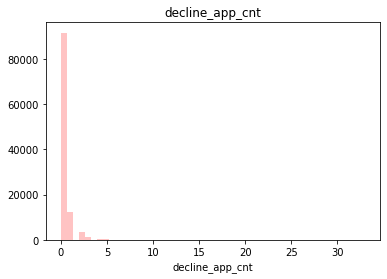

In [26]:
# построим график распределения признака
plt.figure()
sns.distplot(df['decline_app_cnt'], kde=False, rug=False, color=custom_colors[0])
plt.title('decline_app_cnt')
plt.show()

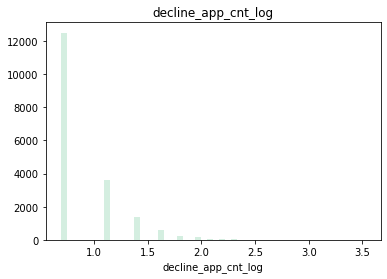

In [27]:
# У признака decline_app_cnt также тяжелый правый хвост, прологарифмируем его и построим новую гистограмму
df['decline_app_cnt_log'] = df.decline_app_cnt.apply(lambda x: np.log(x + 1))

plt.figure()
sns.distplot(df['decline_app_cnt_log']
             [df['decline_app_cnt_log'] > 0].dropna(), kde=False, rug=False, color=custom_colors[1])
plt.title('decline_app_cnt_log')
plt.show()

In [28]:
# можем заметить, что большинство клиентов не имеют отклоненных заявок
df.decline_app_cnt.describe()

count    110148.000000
mean          0.273205
std           0.799099
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          33.000000
Name: decline_app_cnt, dtype: float64

In [29]:
# если у клиента более 3-х отклоненных заявок, то скорее всего предыдущие разы он не прошел проверку
# и был сочтен неблагонадежным заемщиком - учтем это в новой переменной decline_cat
df['decline_cat'] = df['decline_app_cnt'].apply(
    lambda x: 1 if x >= 3 else 0)

### bki_request_cnt

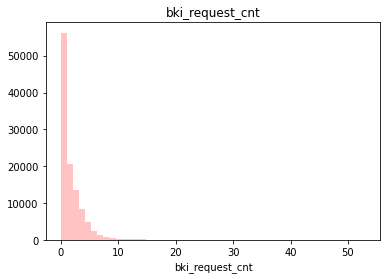

In [30]:
# Построим график распределения признака
plt.figure()
sns.distplot(df['bki_request_cnt'], kde=False, rug=False, color=custom_colors[0])
plt.title('bki_request_cnt')
plt.show()

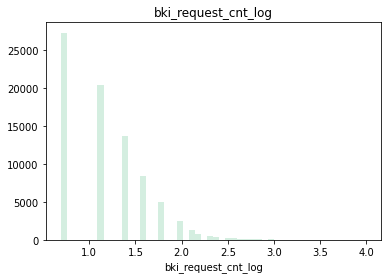

In [31]:
# Как и у предыдущих признаков, у признака bki_request_cnt тяжелый правый хвост,
# прологарифмируем признак и построим новую гистограмму
df['bki_request_cnt_log'] = df.bki_request_cnt.apply(lambda x: np.log(x + 1))

plt.figure()
sns.distplot(df['bki_request_cnt_log']
             [df['bki_request_cnt_log'] > 0].dropna(), kde=False, rug=False, color=custom_colors[1])
plt.title('bki_request_cnt_log')
plt.show()

In [32]:
# Если у клиента много запросов в БКИ, то скорее всего он часто обращается за кредитами и имеет долги
# введем доп переменную: 0 - если у клиента <3 запросов в БКИ и 1 - если >3
df['bki_cnt_many'] = df.bki_request_cnt.apply(lambda x: 0 if x < 3 else 1)

## income

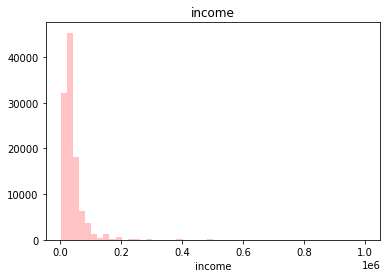

In [33]:
# Построим график распределения признака
plt.figure()
sns.distplot(df['income'], kde=False, rug=False, color=custom_colors[0])
plt.title('income')
plt.show()

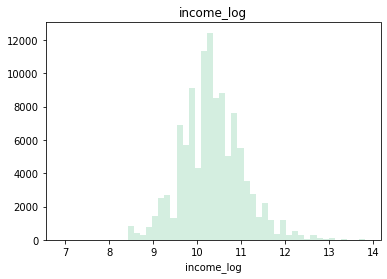

In [34]:
# Как и у предыдущих признаков, у признака income тяжелый правый хвост,
# прологарифмируем признак и построим новую гистограмму
df['income_log'] = df.income.apply(lambda x: np.log(x + 1))

plt.figure()
sns.distplot(df['income_log'][df['income_log'] >
                              0].dropna(), kde=False, rug=False, color=custom_colors[1])
plt.title('income_log')
plt.show()

In [35]:
df.income.describe()

count     110148.000000
mean       41012.648537
std        45399.735051
min         1000.000000
25%        20000.000000
50%        30000.000000
75%        48000.000000
max      1000000.000000
Name: income, dtype: float64

In [36]:
# Разделим клиентов на 4 группы по доходу, используя квартили
perc25 = np.percentile(df.income, 25)
median = np.percentile(df.income, 50)
perc75 = np.percentile(df.income, 75)

df['group_of_income'] = df.income.apply(
    lambda x: group_col(x, perc25, median, perc75))

### score_bki

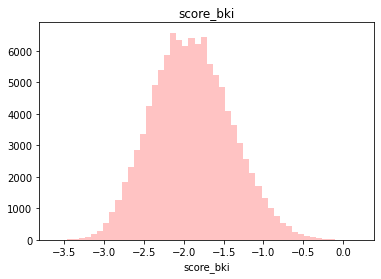

In [37]:
# Построим график распределения признака
plt.figure()
sns.distplot(df['score_bki'], kde=False, rug=False, color=custom_colors[0])
plt.title('score_bki')
plt.show()

У данного признака распределение нормальное, в логарифмировании не нуждается

In [38]:
# Масштабируем числовые переменные
scaler = RobustScaler()
df[num_cols] = scaler.fit_transform(df[num_cols].values)

## Бинарные переменные

In [39]:
df[bin_cols]

sex car car_type foreign_passport  good_work
0        M   Y        Y                N          0
1        F   N        N                N          0
2        M   Y        N                Y          0
3        F   N        N                N          0
4        M   N        N                Y          1
...     ..  ..      ...              ...        ...
110143   F   N        N                N          0
110144   F   Y        Y                N          0
110145   M   N        N                N          0
110146   F   N        N                N          0
110147   M   N        N                N          0

[110148 rows x 5 columns]

In [40]:
# для всех бинарных переменных отобразим каждое значение категории в уникальное число
label_encoder = LabelEncoder()
for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])
df.head()

client_id   app_date education  sex       age  car  car_type  \
0      25905 2014-02-01       SCH    1  1.388889    1         1   
1      63161 2014-03-12       SCH    0  1.222222    0         0   
2      25887 2014-02-01       SCH    1 -0.666667    1         0   
3      16222 2014-01-23       SCH    0  0.888889    0         0   
4     101655 2014-04-18       GRD    1  0.611111    0         0   

   decline_app_cnt  good_work  score_bki  ...  app_month  days_since_app_date  \
0              0.0          0  -0.126966  ...          2                 2825   
1              0.0          0   0.561041  ...          3                 2786   
2              2.0          0   0.740284  ...          2                 2825   
3              0.0          0  -0.197313  ...          1                 2834   
4              0.0          1   0.976254  ...          4                 2749   

    age_log  group_of_age  decline_app_cnt_log  decline_cat  \
0  4.143135             4             0.000000            0   
1  4.094345             4             0.000000            0   
2  3.258097             1             1.098612            0   
3  3.988984             4             0.000000            0   
4  3.891820             3             0.000000            0   

   bki_request_cnt_log  bki_cnt_many  income_log  group_of_income  
0             0.693147             0    9.798183                1  
1             1.386294             1    9.852247                1  
2             0.693147             0   10.308986                2  
3             1.098612             0    9.210440                1  
4             0.693147             0   10.308986                2  

[5 rows x 30 columns]

## Категориальные переменные

In [41]:
# Перекодируем признаки в зависимости от уровня образования
education_dict = {
    'SCH': 1,
    'UGR': 2,
    'GRD': 3,
    'PGR': 4,
    'ACD': 5
}

# Заполним пропуски
df['education'] = fill_na_values('education', df)

df['education'] = df['education'].replace(to_replace=education_dict)

# Значимость признаков

<AxesSubplot:>

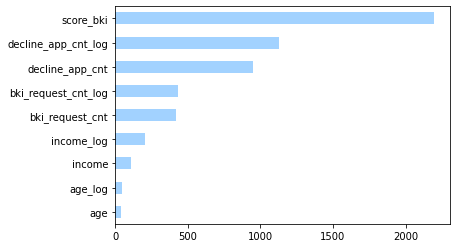

In [42]:
# оценим значимость числовых переменных c помощью функции f_classif
num_cols = [
    'age',
    'age_log',
    'decline_app_cnt',
    'decline_app_cnt_log',
    'score_bki',
    'bki_request_cnt',
    'bki_request_cnt_log',
    'income',
    'income_log',
]
imp_num = pd.Series(f_classif(df[num_cols], df['default'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh', color=custom_colors[2])

In [43]:
# Как видим, логарифмированные переменные вносят больший вклад, оставим только их
num_cols = [
    'age_log',
    'decline_app_cnt_log',
    'score_bki',
    'bki_request_cnt_log',
    'income_log'
]

<AxesSubplot:>

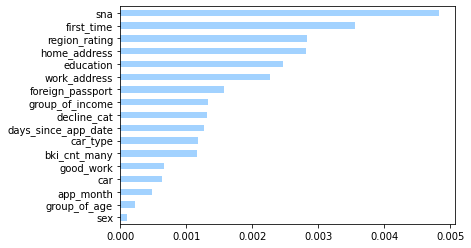

In [44]:
# Оценим значимость категориальных и бинарных переменных c помощью функции mutual_info_classif
cat_bin_cols = ['education', 'region_rating', 'home_address', 'sna', 'first_time',
                'sex', 'car', 'car_type', 'work_address', 'foreign_passport', 'good_work',
                'group_of_age', 'bki_cnt_many',
                'group_of_income', 'app_month', 'days_since_app_date', 'decline_cat']
imp_cat = pd.Series(mutual_info_classif(df[cat_bin_cols], df['default'],
                                        discrete_features=True), index=cat_bin_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh',color=custom_colors[2])

In [45]:
# удалим ненужные признаки из датафрейма
drop_col = [
    'age',
    'decline_app_cnt',
    'bki_request_cnt',
    'income'
]

df = df.drop(drop_col, axis=1)

In [46]:
# преобразуем категориальные признаки в dummy-переменные
df = pd.get_dummies(df, columns=cat_cols)

# Обучение модели

In [47]:
train_data = df.query('sample == 1').drop(
    ['sample', 'client_id', 'app_date'], axis=1)
test_data = df.query('sample == 0').drop(
    ['sample', 'client_id', 'app_date'], axis=1)

# разделяем выборки на тестовую и валидационную
X = train_data.drop(['default'], axis=1)
y = train_data['default']

X_test = test_data.drop(['default'], axis=1)

In [48]:
# сформируем выборку таким образом, чтобы решить проблему дисбаланса
zeros = y[y == 0]
ones = y[y == 1]
down_index = list(zeros.index[:len(ones)]) + list(ones.index)
down_index
x_down = X.loc[down_index, :]
y_down = y[down_index]

In [49]:
# разделяем выборку на тренировочную и валидационную
X_train, X_val, y_train, y_val = train_test_split(
    x_down, y_down, test_size=0.2, random_state=RANDOM_SEED)

In [50]:
# Проверяем данные
test_data.shape, train_data.shape, X.shape, X_train.shape, X_val.shape

((36349, 43), (73799, 43), (73799, 42), (14995, 42), (3749, 42))

In [51]:
# Проводим стандартизацию
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [52]:
# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 2.7825594022071245


In [53]:
# обучаем модель
model = LogisticRegression(
    max_iter=1000, random_state=RANDOM_SEED, C=1, penalty='l2')

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_val)[:, 1]
y_pred = model.predict(X_val)

[[1275  612]
 [ 584 1278]]


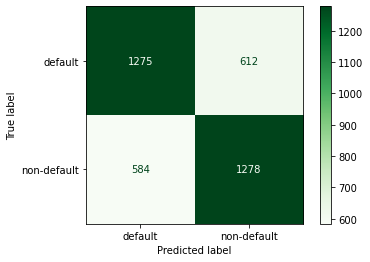

In [54]:
# построим confusion matrix
disp = plot_confusion_matrix(model, X_val, y_val,
                             display_labels=['default', 'non-default'],
                             cmap=plt.cm.Greens)
print(disp.confusion_matrix)

In [55]:
# сравним f1-score для тестовой и валидационной выборки
y_pred = model.predict(X_train)
f1_train = f1_score(y_train, y_pred)
print('[train] F1-score = {:.2f}'.format(f1_train))

y_pred = model.predict(X_val)
f1_val = f1_score(y_val, y_pred)
print('[valid] F1-score = {:.2f}'.format(f1_val))

[train] F1-score = 0.67
[valid] F1-score = 0.68


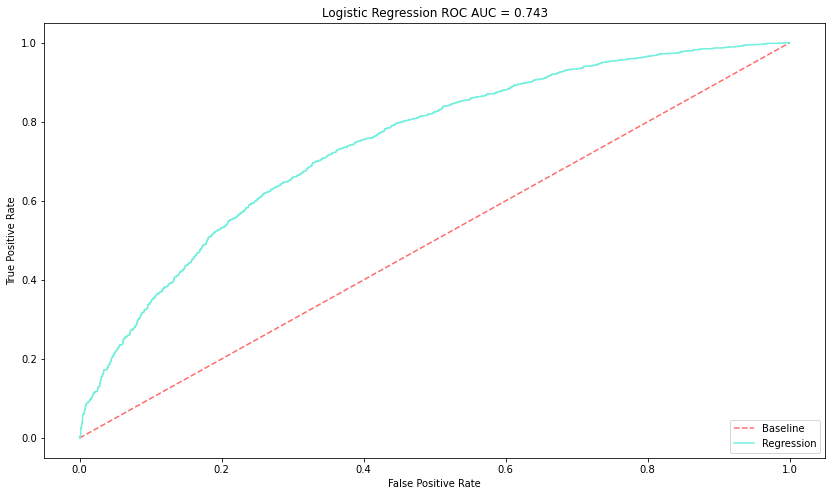

In [56]:
# построим ROC AUC для нашей модели
fpr, tpr, threshold = roc_curve(y_val, y_pred_prob)
roc_auc = roc_auc_score(y_val, y_pred_prob)

plt.figure(figsize=(14, 8))
plt.plot([0, 1], label='Baseline', linestyle='--', color=custom_colors[0])
plt.plot(fpr, tpr, label='Regression', color = custom_colors[3])
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [57]:
# получим вероятностные оценки нашей модели для тестовой выборки
y_pred_prob = model.predict_proba(X_test)[:, 1]

In [58]:

submit = pd.DataFrame(df_test.client_id)
submit['default'] = y_pred_prob
submit.to_csv('submission.csv', index=False)
submit = submit.reset_index().drop('index', axis=1)
submit.head()

client_id   default
0      74835  0.198013
1      17527  0.775673
2      75683  0.295184
3      26883  0.407694
4      28862  0.123795

In [59]:
# определим диапазон для параметров модели XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [60]:
# создадим новую модель
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

In [61]:
# найдем лучшие гиперпараметры модели при помощи перебора параметров по сетке с последующей кросс-валидацией. 
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=RANDOM_SEED)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb,
                                   scoring='roc_auc', n_jobs=4, cv=skf.split(X_train, y_train), verbose=3, random_state=RANDOM_SEED)

random_search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:   41.7s finished


[06:22:50] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[06:22:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f1025a0f250>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=0.02,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing...
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=None,
                                           scale_pos_weight=None, silent=True,
                                           subsa

In [62]:
# сравним f1-score для тестовой и валидационной выборки - значительно лучше, чем у предыдущей модели
y_pred = random_search.predict(X_train)
f1_train = f1_score(y_train, y_pred)
print('[train] F1-score = {:.2f}'.format(f1_train))

y_pred = random_search.predict(X_val)
f1_val = f1_score(y_val, y_pred)
print('[valid] F1-score = {:.2f}'.format(f1_val))

[train] F1-score = 0.69
[valid] F1-score = 0.69


In [63]:
# получим вероятностные оценки нашей модели для валидационной выборки
y_pred_prob = random_search.predict_proba(X_val)[:, 1]

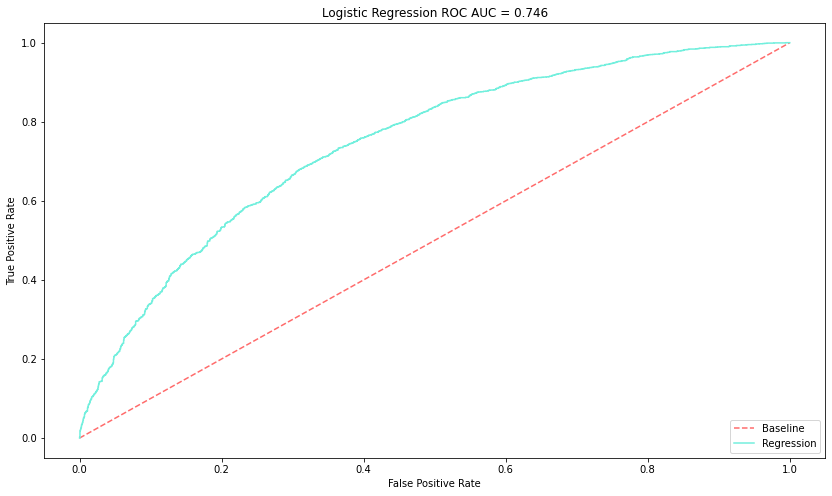

In [64]:
# построим ROC AUC 
fpr, tpr, threshold = roc_curve(y_val, y_pred_prob)
roc_auc = roc_auc_score(y_val, y_pred_prob)

plt.figure(figsize=(14, 8))
plt.plot([0, 1], label='Baseline', linestyle='--', color=custom_colors[0])
plt.plot(fpr, tpr, label='Regression',color=custom_colors[3])
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [65]:
y_pred_prob = random_search.predict_proba(X_test)[:, 1]

[[1252  635]
 [ 553 1309]]


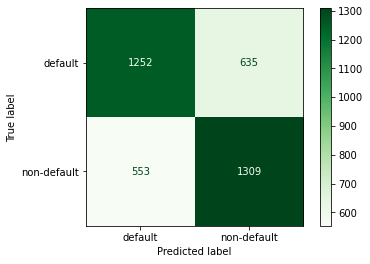

In [66]:
# построим confusion matrix
disp = plot_confusion_matrix(random_search, X_val, y_val,
                             display_labels=['default', 'non-default'],
                             cmap=plt.cm.Greens)
print(disp.confusion_matrix)


In [67]:
submit = pd.DataFrame(df_test.client_id)
submit['default'] = y_pred_prob
submit.to_csv('submission.csv', index=False)
submit = submit.reset_index().drop('index', axis=1)
submit.head()

client_id   default
0      74835  0.201567
1      17527  0.634865
2      75683  0.341927
3      26883  0.366901
4      28862  0.134859